In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from collections import Counter

In [22]:
from LabData.DataLoaders.MentalLoader import MentalLoader
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader

In [23]:
data=MentalLoader().get_data().df
metadata = MentalLoader().get_data().df_metadata
cols_meta = MentalLoader().get_data().df_columns_metadata

data_subject = SubjectLoader().get_data().df
metadata_Subject = SubjectLoader().get_data().df_metadata
cols_meta_Subject = SubjectLoader().get_data().df_columns_metadata

data_body = BodyMeasuresLoader().get_data().df
metadata_body = BodyMeasuresLoader().get_data().df_metadata
cols_meta_body = BodyMeasuresLoader().get_data().df_columns_metadata

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [25]:
#validation that values of the index secound level can be converert to datetime type
data.index.set_levels(pd.to_datetime(data.index.levels[1]), level=1).get_level_values(1).dtype == 'datetime64[ns, UTC]'

True

**Create a list of participants for future analysis**\
listing only 10k participnts and only until january 2024
with values of -1

In [26]:
# #filtering participants with values of -1
# participants_10k=set(metadata[metadata[metadata["StudyTypeID"]==[num for num in metadata["StudyTypeID"] if str(num).startswith('10') and num != 1000]]. #all 10k participants
#                               index.get_level_values(1)< '2024-02-01 00:00:00'].index.droplevel(1)) #only until january 2024

# df = data.loc[(participants_10k, slice(None, '2024-02-01 00:00:00')),:]

# df.to_hdf('data_new_.h5', key='df', mode='w')

In [27]:
#open df
df_base = pd.read_hdf('data_new_.h5', 'df')

RDS across time 

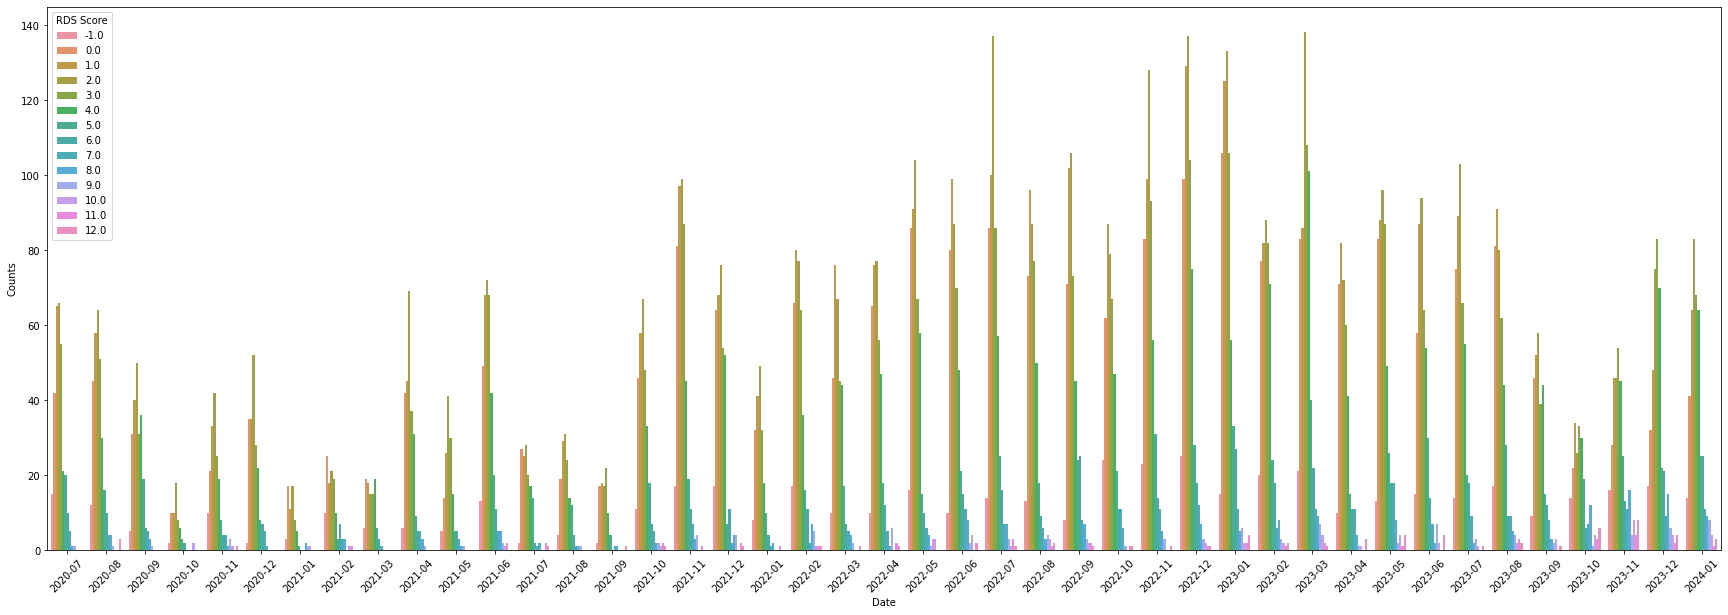

In [28]:
#ploting the rds score across time 
def plot_rds_acros_time():   
    
    df= df_base.copy()
    df.index = pd.MultiIndex.from_arrays([df.index.get_level_values(0), pd.to_datetime(df.index.get_level_values(1)).strftime('%Y-%m')],names=df.index.names)
    df = df.reset_index().groupby(['Date','rds_score']).count()[['RegistrationCode']].drop(index='2020-06').reset_index()
    
    plt.figure(figsize=(30, 10)) 
    ax = sns.barplot(data= df , x='Date', y="RegistrationCode", hue='rds_score')
    _ = ax.set_ylabel('Counts')
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    _ = ax.legend(title='RDS Score', loc='upper left')
    
    return

plot_rds_acros_time()

In [29]:
def creating_base_df():

    df = df_base.copy()[['rds_score']] 
  
    df_subject= data_subject.copy().loc[df.index.get_level_values(0).unique()][['month_of_birth','yob','gender']]
    df_subject = df_subject[['month_of_birth','yob','gender']]
    
    df_body = data_body.copy().loc[[idx for idx in df.index.get_level_values(0).drop_duplicates() if idx in data_body.index]][['bmi']]
    
    # change date to y/m/d
    dfs = [df, df_subject, df_body]
    for local_df in dfs:
        local_df.index = pd.MultiIndex.from_arrays([local_df.index.get_level_values(0), pd.to_datetime(local_df.index.get_level_values(1)).date],names=local_df.index.names)

    #fill the nan values 
    df = pd.concat([df, df_body, df_subject]).sort_index()
    for col in ['month_of_birth','yob','gender']:
        df[col] = df.groupby('RegistrationCode')[col].apply(lambda x: x.ffill().bfill())
    
    #fixing age
    df['age'] = df.index.get_level_values(1).year - df['yob']
    df['age'] -= (df.index.get_level_values(1).month < df['month_of_birth']) #when true 1 is subtracted
    
    df = df.drop(columns=['yob', 'month_of_birth'])
    
    #make sure that for each participent there is a rds_score
    paticipants = df.dropna(subset= ['rds_score']).index.get_level_values(0).unique()
    df = df[df.index.get_level_values(1) < '2024-02-01'].loc[paticipants]

    #create war df
    war_df = df[df.index.get_level_values(1) > '2023-10-07']
    war_paticipants = war_df.dropna(subset= ['rds_score']).index.get_level_values(0).unique()
    war_df = war_df.loc[war_paticipants]
    
    #create df before war
    before_war = df[df.index.get_level_values(1) < '2023-10-07']
    
    #change in rds score including -1
    stat = mannwhitneyu (war_df['rds_score'].dropna(), before_war['rds_score'].dropna())
    minus_1_prop_before = len(before_war[before_war['rds_score'] == -1]) /len(before_war[before_war['rds_score'] != -1])
    minus_1_prop_war = len(war_df[war_df['rds_score'] == -1]) / len(war_df[war_df['rds_score'] != -1])
    
    prop = (stat, minus_1_prop_before, minus_1_prop_war)
    
    return df, war_df, prop

# creating_base_df()[1]

In [30]:
df, war_df = creating_base_df()[:2]

**group one** *new*\
Same participants before and after the war

In [31]:
def group_1_new(full = df, war = war_df):
    
    #keep measurements from the same seasons
    before_war = full[(full.index.get_level_values(1).month >= 10) | (full.index.get_level_values(1).month == 1)].loc[war.index.get_level_values(0).unique()]
    before_war = before_war.loc[before_war.index.get_level_values(1) < '2023-10-07']

    #drop all -1 
    before_war = before_war.loc[before_war['rds_score'] != -1]
    after_war  = war.loc[war['rds_score'] != -1]
    
    #make sure that for each participent there is a rds_score before and after 
    paticipants_before = before_war.dropna(subset= ['rds_score']).index.get_level_values(0).unique()
    paticipants_after = after_war.dropna(subset= ['rds_score']).index.get_level_values(0).unique()
    paticipants = list(set(paticipants_after).intersection(paticipants_before))
    
    before_war = before_war.loc[paticipants]

    after_war = after_war.loc[before_war.index.get_level_values(0).unique()]
    
    before_after = pd.concat([before_war, after_war], axis=0, keys=["before", "after"], names= ['sub'])
    before_after = before_after
    return before_after

before_after= group_1_new()

In [32]:
def statistics(result):

    result = result.dropna(axis= 1, how='all') 
   
    new_r={}
   
    for col in result.columns:
        local_df = result[col].dropna()
        stat = mannwhitneyu(local_df.loc[result.index.get_level_values(0).unique()[0]], local_df.loc[result.index.get_level_values(0).unique()[1]]) # Mann–Whitney U test for non paremtric data (only age continuous)
        new_r[col] = stat[1]*len(result.columns) #bonfferoni correction

    final = pd.concat([result.groupby('sub').agg(lambda x: (round(x.mean(), 3), round(x.std(), 3))).T, pd.Series(new_r, name="p-val")], axis=1)
    
    final.loc['n'] = np.nan
    
    for sub in result.index.get_level_values(0).unique():
        final[sub].loc['n'] = len(result.loc[sub].index.get_level_values(0).unique())
   
    return final

**group two** *new*\
matched groups

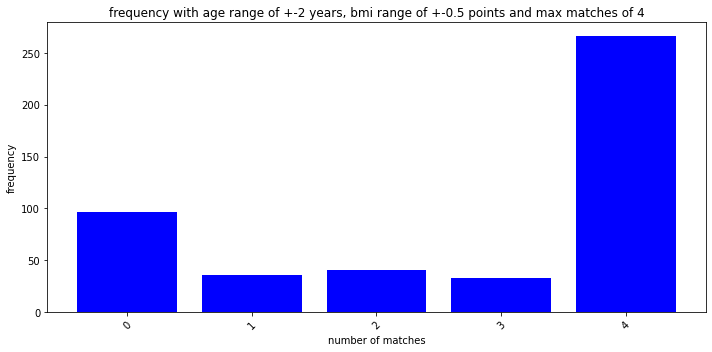

In [33]:
def matching(before_df, after_df, age_range, bmi_range, max_matches):

    before = before_df[before_df['rds_score'] != -1]
    before = before.loc[before.index.get_level_values(1) < '2023-10-07']
    before = before.loc[before.index.get_level_values(1) > '2021-10-07']
     
    after = after_df
    #keep measurements from the same seasons
    before = before[(before.index.get_level_values(1).month >= 10) | (before.index.get_level_values(1).month == 1)]

    dfs = []
    for df in [before, after]:
        
        df['bmi'] = df.groupby('RegistrationCode')['bmi'].apply(lambda x: x.bfill().ffill()) # we are using only the last two years 
        df = df.dropna(subset=['rds_score'])
        df = df.dropna(subset=['bmi']).drop_duplicates(keep= 'last')
        df = df.droplevel(1).drop_duplicates(keep= 'last')
        dfs.append(df)
    
    before = dfs[0]
    after = dfs[1]

    match_dict = {}
    matching_list = []
    for participant in after.index:
        
        temp = before[before['gender'] == after.loc[participant]['gender']]
        participant_age = after.loc[participant]['age']


        temp_filtered = temp[temp['age'].between(participant_age - age_range, participant_age + age_range)]
        
        participant_bmi = after.loc[participant]['bmi']
        
        final = temp_filtered[temp_filtered['bmi'].between(participant_bmi - bmi_range, participant_bmi + bmi_range)]
   
        final_ = final.drop(labels= [idx for idx in matching_list if idx in final.index], axis = 0)
        final_ = final_.head(max_matches)

        match_dict[participant] = final_
        matching_list.extend(final_.index.to_list())
        
 
    ploting_dict = match_dict.copy()
    not_matched = []
    for key, value in ploting_dict.items():
        ploting_dict[key] = len(value)
        if len(value) == 0:
            not_matched.append(key)


    value_counts = list(ploting_dict.values())
    frequency_of_values = Counter(value_counts)

    values, counts = zip(*frequency_of_values.items())
    fig = plt.figure(figsize=(10, 5))

    plt.xticks(rotation=45)
    plt.bar(values, counts, color='blue')
    plt.xlabel('number of matches')
    plt.ylabel('frequency')
    plt.title(f'frequency with age range of +-{age_range} years, bmi range of +-{bmi_range} points and max matches of {max_matches}')
    plt.xticks(values) 
    plt.tight_layout()
    plt.show()
    
    after_not_matched = after.loc[not_matched]
    
    final_after = after.loc[match_dict.keys()]
    final_before = before.loc[matching_list]
    
    matching = pd.concat([final_before, final_after], axis=0, keys=["before", "after"], names= ['sub'])
    
    return matching#, after_not_matched

matching_df= matching(before_df= df, after_df = war_df, age_range = 2, bmi_range = 0.5, max_matches = 4)

**group three** *new*\
high and low rds within the war

No handles with labels found to put in legend.
/usr/wisdom/python/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


RegistrationCode    0.233333
dtype: float64 RegistrationCode    0.245238
dtype: float64


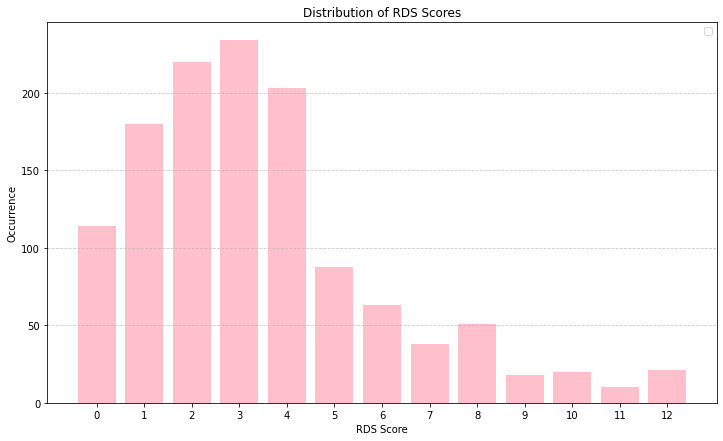

In [34]:
def group_3_pre_ploting(df = war_df):

    group_3_df = df[df['rds_score'] != -1]
    prevalence = group_3_df.reset_index().groupby('rds_score').count()[['RegistrationCode']]

    fig = plt.figure(figsize=(12, 7))
    _ = plt.bar(prevalence.index, prevalence['RegistrationCode'], color='pink')
    _ = plt.xlabel('RDS Score')
    _ = plt.ylabel('Occurrence')
    _ = plt.title('Distribution of RDS Scores')
    _ = plt.xticks(prevalence.index)
    _ = plt.legend()
    _ = plt.grid(axis='y', linestyle='--', alpha=0.7)
    fig.show()

    # percentage of the highest rds group and the lowest
    print((prevalence.loc[[0,1]]).sum()/prevalence.sum() ,(prevalence.iloc[5:]).sum()/prevalence.sum()) 
    
    return #prevalence

group_3_pre_ploting()

In [35]:
def group_3_new(df, first_q, last_q):

    minus = df[df['rds_score'] == -1]
    group_3_df = df[df['rds_score'] != -1]
    low_rds = group_3_df[group_3_df['rds_score'] <= first_q]
    high_rds = group_3_df[group_3_df['rds_score'] >= last_q]
    high_low = pd.concat([low_rds, high_rds, minus], axis=0, keys=['low', 'high', '-1'], names= ['sub'])

    return high_low

high_low_df = group_3_new(war_df, 1, 5)

In [37]:
statistics(result= high_low_df) #p-val just between low and high

/usr/wisdom/python/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,low,high,-1,p-val
rds_score,"(0.612, 0.488)","(7.172, 2.127)","(-1.0, 0.0)",1.809461e-103
bmi,"(26.792, 4.332)","(26.289, 4.947)","(25.399, 4.268)",1.098914e+00
gender,"(0.677, 0.468)","(0.262, 0.441)","(0.263, 0.444)",8.066895e-24
age,"(54.493, 9.893)","(50.395, 8.998)","(50.825, 11.211)",2.091754e-07
n,294,309,57,NaN


In [38]:
statistics(result= matching_df)

/usr/wisdom/python/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,before,after,p-val
rds_score,"(2.306, 1.872)","(3.038, 2.683)",7.151202e-07
bmi,"(25.7, 3.507)","(26.346, 4.395)",2.291656e-01
gender,"(0.457, 0.498)","(0.452, 0.498)",3.420529e+00
age,"(53.137, 7.503)","(51.51, 11.435)",3.469637e-01
n,1198,473,NaN


In [39]:
statistics(result= before_after)

/usr/wisdom/python/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,before,after,p-val
rds_score,"(2.419, 1.968)","(3.526, 2.727)",1.811372e-11
bmi,"(26.18, 4.054)","(26.425, 3.992)",1.696637e+00
gender,"(0.496, 0.5)","(0.485, 0.5)",2.635975e+00
age,"(51.917, 7.844)","(53.928, 8.085)",5.671368e-07
n,523,523,NaN


In [40]:
#rds -1 before and after the war######## how to calculate the diff
def prevalence_of_minus_one_before_after(df = df):
    
    df_minus = df[df['rds_score'] == -1]
    df_with_score = df[df['rds_score'] != -1]
    after = len(df_minus.loc[df_minus.index.get_level_values(1) > '2023-10-07'])/len(df_with_score.loc[df_with_score.index.get_level_values(1) > '2023-10-07'])
    before = len(df_minus.loc[df_minus.index.get_level_values(1) < '2023-10-07'])/len(df_with_score.loc[df_with_score.index.get_level_values(1) < '2023-10-07'])
   
    stat = mannwhitneyu(df_minus.loc[df_minus.index.get_level_values(1) < '2023-10-07']['rds_score'], df_minus.loc[df_minus.index.get_level_values(1) > '2023-10-07']['rds_score'])

    return before, after, stat

prevalence_of_minus_one_before_after()

(0.013557380179492075,
 0.02186421173762946,
 MannwhitneyuResult(statistic=16188.0, pvalue=1.0))